In [1]:
import sys
sys.path.append('nam')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import torch

In [4]:
from itertools import combinations

In [5]:
import numpy as np
import pandas as pd
import sklearn.metrics as sk_metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import random_split

from nam.wrapper import NAMClassifier, MultiTaskNAMClassifier

/mnt/idms/kdomokos/ericcson/rishap/supplementary/nam/nam/nam/trainer/trainer.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
random_state = 2016

In [7]:
import data_utils
data_x, data_y, columns = data_utils.load_dataset("Recidivism")
original_dfs = data_utils.load_recidivism_data()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=random_state)

In [9]:
device="cuda:7"

In [10]:
%%time
single_models = []
for i in range(len(columns)):
    X_train_f = X_train[:, i:i+1]
    X_test_f = X_test[:, i:i+1]
    model = NAMClassifier(
        num_epochs=1000,
        num_learners=20,
        metric='auroc',
        early_stop_mode='max',
        monitor_loss=False,
        n_jobs=10,
        random_state=random_state,
        device=device
    )

    model.fit(X_train_f, y_train)
    pred = model.predict_proba(X_test_f)
    print(columns[i], sk_metrics.roc_auc_score(y_test, pred))
    single_models.append(model)

age 0.6012683218346646
race 0.5735968155891
sex 0.5393249134264966
priors_count 0.6194020692267879
length_of_stay 0.5006402970978534
c_charge_degree 0.5686478526036081
CPU times: user 53.8 s, sys: 7.03 s, total: 1min
Wall time: 1min 59s


In [11]:
%%time
double_models = {}
for i,j in combinations(range(len(columns)), 2):
    X_train_f = X_train[:, [i,j]]
    X_test_f = X_test[:, [i,j]]
    model = NAMClassifier(
        num_epochs=1000,
        num_learners=20,
        metric='auroc',
        early_stop_mode='max',
        monitor_loss=False,
        n_jobs=10,
        random_state=random_state,
        device=device
    )

    model.fit(X_train_f, y_train)
    pred = model.predict_proba(X_test_f)
    print(columns[i], columns[j], sk_metrics.roc_auc_score(y_test, pred))
    double_models[(i,j)] = model

age race 0.6205892867623911
age sex 0.6391152161269495
age priors_count 0.7430861252954705
age length_of_stay 0.5690560420034896
age c_charge_degree 0.6433625202093771
race sex 0.5820940916585295
race priors_count 0.6812120824062364
race length_of_stay 0.5421635638936466
race c_charge_degree 0.5915864961342063
sex priors_count 0.6872682257900998
sex length_of_stay 0.5710169518656656
sex c_charge_degree 0.5876033146046432
priors_count length_of_stay 0.666071723946578
priors_count c_charge_degree 0.6851339021305886
length_of_stay c_charge_degree 0.6013830417313634
CPU times: user 2min 52s, sys: 12.3 s, total: 3min 5s
Wall time: 7min 27s


In [12]:
%%time
full_model = NAMClassifier(
    num_epochs=1000,
    num_learners=20,
    metric='auroc',
    early_stop_mode='max',
    monitor_loss=False,
    n_jobs=10,
    random_state=random_state,
    device=device
)

full_model.fit(X_train, y_train)
pred = full_model.predict_proba(X_test)
sk_metrics.roc_auc_score(y_test, pred)

CPU times: user 22 s, sys: 1.92 s, total: 24 s
Wall time: 1min 2s


0.7447055433721246

In [13]:
titles = {
    'age':'Age', 'race':'Race', 'sex':'Gender', 'priors_count':'Priors Count', 'length_of_stay': 'Length of Stay', 'c_charge_degree': 'Charge Degree',
}
xticks = {
    'sex': {'labels':['Female', 'Male']},
    'race': {'labels': ["African\nAmerican", 'Asian', 'Caucasian', 'Hispanic', "Native\nAmerican", 'Other'], 'rotation':90}
}
def special_step(*args, **kwargs):
    x,y,*z = args
    x0 = 2*x[0]-x[1]
    xn = 2*x[-1]-x[-2]
    xx = np.concatenate([[x0], x, [xn]])
    yy = np.concatenate([[y[0]], y, [y[-1]]])
    plt.step(xx, yy, *z, **kwargs)
    plt.xlim((xx[0]+xx[1])/2, (xx[-2]+xx[-1])/2)

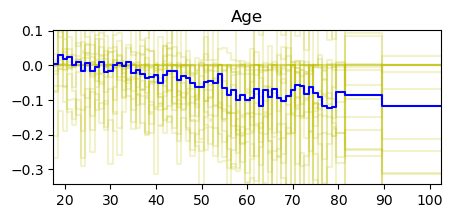

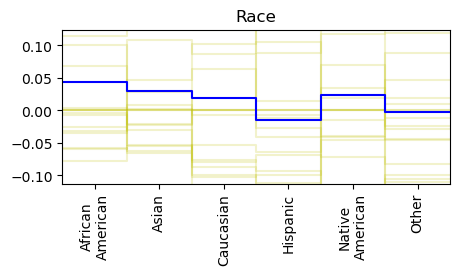

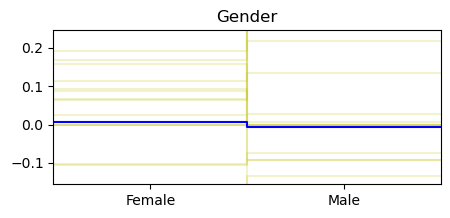

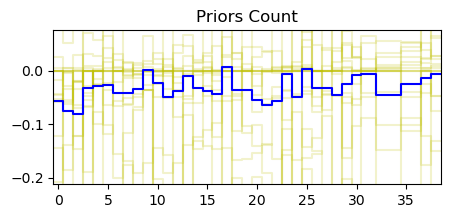

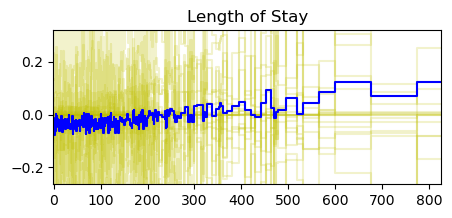

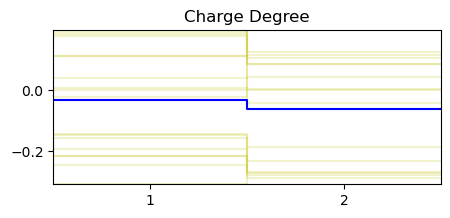

In [14]:
with torch.no_grad():
    for i, (model, colname) in enumerate(zip(single_models, columns)):
        vX = np.sort(original_dfs['X'][colname].unique())
        X = np.zeros((len(vX), 1))
        X[:, 0] = np.sort(np.unique(data_x[:, i]))
        lines = []
        model = single_models[i]
        for m in model.models:
            out = m.forward(torch.tensor(X, dtype=torch.float32))[1][:,0]
            lines.append(out.cpu().numpy())
        plt.figure(figsize=(5,2))
        plt.tight_layout()
        plt.title(titles[colname])
        for l in lines:
            special_step(vX, l, color='y', alpha=0.2, where='mid')
        special_step(vX, np.mean(lines, axis=0), color='b', linestyle='-', where='mid')
        
        if colname in xticks:
            plt.xticks(vX, **xticks[colname])
        elif len(vX) < 10:
            plt.xticks(vX)
        plt.ylim(
            np.percentile(lines, 20, axis=0).min()-np.abs(np.percentile(lines, 20, axis=0).min()*0.1),
            np.percentile(lines, 80, axis=0).max()+np.abs(np.percentile(lines, 80, axis=0).max()*0.1),
        )
        plt.savefig('out/recidivism_solo_%d.png'%i)
        plt.show()

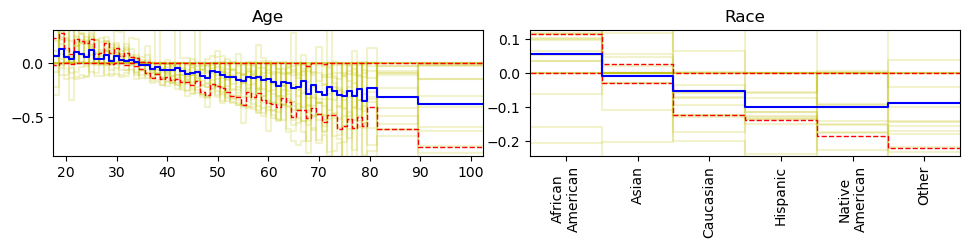

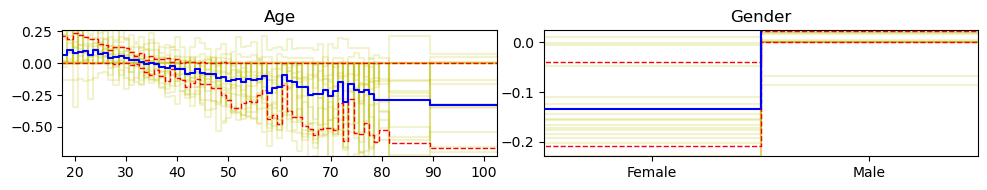

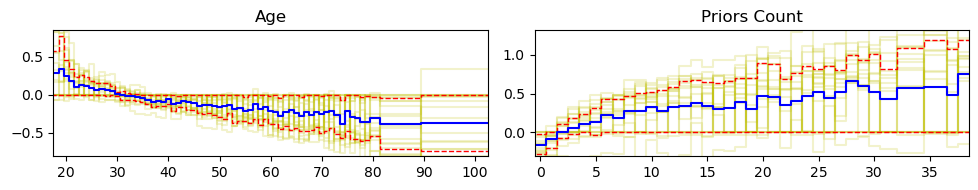

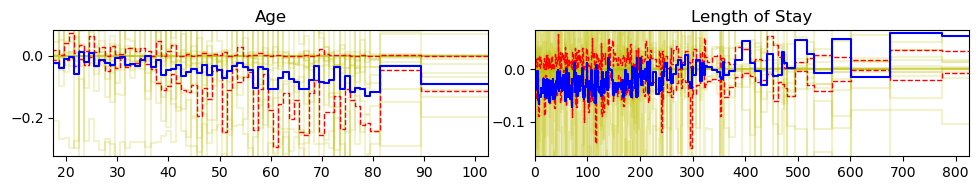

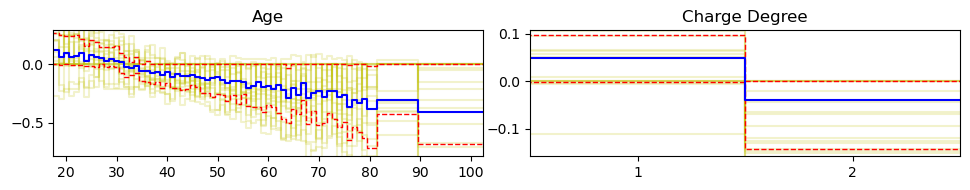

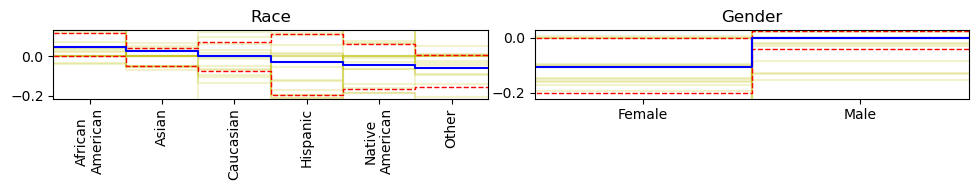

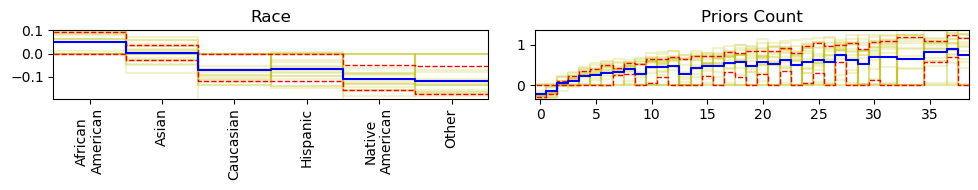

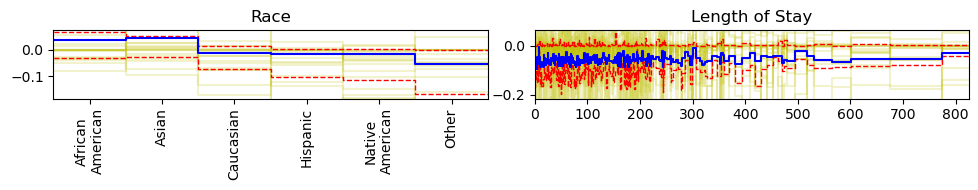

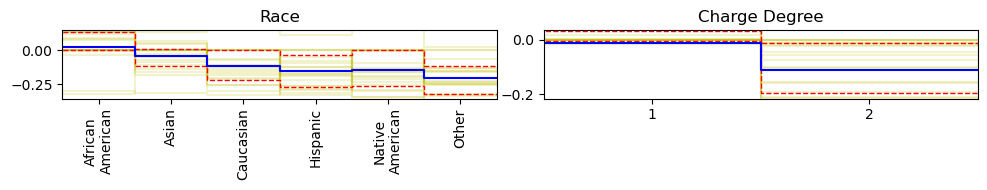

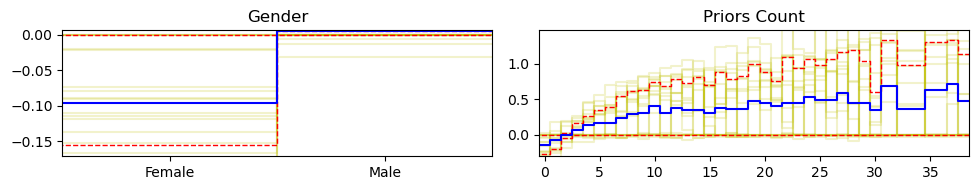

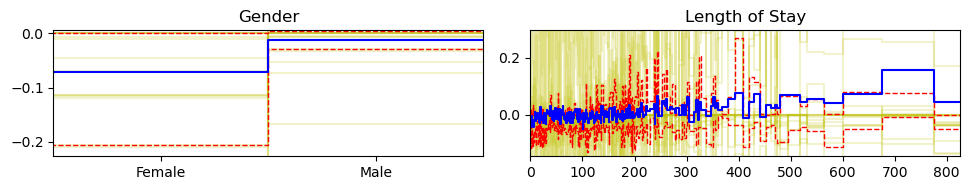

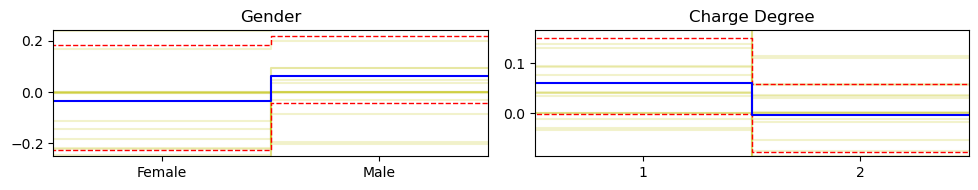

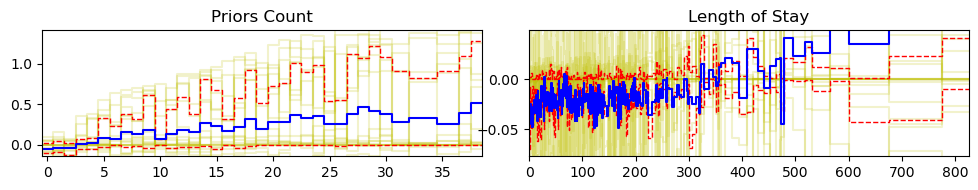

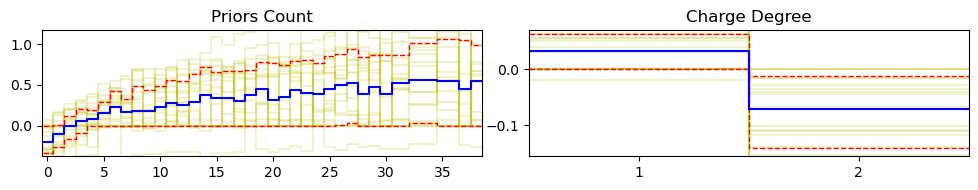

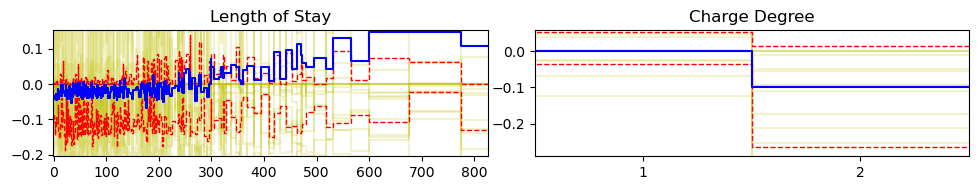

In [15]:
with torch.no_grad():
    for z, (j,k) in enumerate(combinations(range(len(columns)), 2)):
        two_cols = [columns[j], columns[k]]
        model = double_models[(j,k)]
        plt.figure(figsize=(10,2))
        for i, colname in zip(range(len(two_cols)), two_cols):
            vX = np.sort(original_dfs['X'][colname].unique())
            X = np.zeros((len(vX), 2))
            X[:, i] = np.sort(np.unique(data_x[:, [j,k][i]]))
            lines = []
            for m in model.models:
                out = m.forward(torch.tensor(X, dtype=torch.float32))[1][:,i]
                lines.append(out.cpu().numpy())
                
            plt.subplot(1, 2, i+1)
            plt.tight_layout()
            plt.title(titles[colname])
            for l in lines:
                special_step(vX, l, color='y', alpha=0.2, where='mid')
            special_step(vX,  np.percentile(lines, 80, axis=0), color='r', linestyle='--', lw=1, where='mid')
            special_step(vX,  np.percentile(lines, 20, axis=0), color='r', linestyle='--', lw=1, where='mid')
            special_step(vX, np.mean(lines, axis=0), color='b', linestyle='-', where='mid')

            #plt.xlim(vX.min(), vX.max())
            if colname in xticks:
                plt.xticks(vX, **xticks[colname])
            elif len(vX) < 10:
                plt.xticks(vX)
            plt.ylim(
                np.percentile(lines, 20, axis=0).min()-np.abs(np.percentile(lines, 20, axis=0).min()*0.1),
                np.percentile(lines, 80, axis=0).max()+np.abs(np.percentile(lines, 80, axis=0).max()*0.1),
            )
            #plt.show()
        plt.savefig("out/recidivism_double_%d.png"%z)

# variances of partial models

In [16]:
full_logit = super(NAMClassifier, full_model).predict(X_train)
single_logits = [super(NAMClassifier, m).predict(X_train[:,[i]]) for i, m in enumerate(single_models)]
double_logits = {k: super(NAMClassifier, m).predict(X_train[:, k]) for k, m in double_models.items()}

In [17]:
for i, pred in enumerate(single_logits):
    print(columns[i], sk_metrics.roc_auc_score(y_train, pred))

age 0.58811289406231
race 0.5706844726897973
sex 0.5428114182279418
priors_count 0.6239436619718309
length_of_stay 0.5196991517585815
c_charge_degree 0.5366725682424754


In [18]:
for (i,j), pred in double_logits.items():
    print(columns[i], columns[j], sk_metrics.roc_auc_score(y_train, pred))

age race 0.6258951457336892
age sex 0.6171976983854345
age priors_count 0.7324146803900324
age length_of_stay 0.5688091258621145
age c_charge_degree 0.6175580688634621
race sex 0.5950202150992258
race priors_count 0.6891910326876833
race length_of_stay 0.5673166107338213
race c_charge_degree 0.5932210052057184
sex priors_count 0.6847098538699363
sex length_of_stay 0.5648001281610866
sex c_charge_degree 0.5684333958724203
priors_count length_of_stay 0.6715234653700816
priors_count c_charge_degree 0.6860794929048966
length_of_stay c_charge_degree 0.5731533903231774


In [19]:
def var(x):
    return np.mean((x-x.mean())**2)

In [20]:
full_var = var(full_logit)
full_var

0.2127636752030011

In [21]:
r2_single = []
for i,sl in enumerate(single_logits):
    print(columns[i], var(sl-full_logit)/full_var)
    r2_single.append(1-var(sl-full_logit)/full_var)

age 0.9571175178839301
race 0.9644853947217054
sex 0.983432936979798
priors_count 0.9545131078846253
length_of_stay 0.9949684824351169
c_charge_degree 0.9714869508525935


In [22]:
# indeed doesn't seem to be well-calibrated!

In [23]:
r2_double = {}
for i,j in double_logits.keys():
    print(columns[i], columns[j], var(double_logits[(i,j)]-full_logit)/full_var)
    r2_double[(i,j)] = (1-var(double_logits[(i,j)]-full_logit)/full_var)
    r2_double[(j,i)] = (1-var(double_logits[(i,j)]-full_logit)/full_var)

age race 0.772694954465904
age sex 0.8266910357604608
age priors_count 0.37480455113612915
age length_of_stay 0.968811781982341
age c_charge_degree 0.8115905877930665
race sex 0.8852161585789591
race priors_count 0.4023943534645589
race length_of_stay 0.9525642185293133
race c_charge_degree 0.8050425959067699
sex priors_count 0.5334949243555663
sex length_of_stay 0.9601778593908897
sex c_charge_degree 0.9307415730426851
priors_count length_of_stay 0.7259835743114611
priors_count c_charge_degree 0.5223620885550728
length_of_stay c_charge_degree 0.9304871091271895


In [24]:
# but these are much better, apparently nam need at least two features

In [25]:
# markdown tables

In [26]:
print("", *columns, sep="|", end="|\n")
print("", *(["---"]*len(columns)), sep="|", end="|\n")
print("", *["%.3f"%v for v in r2_single], sep="|", end="|\n")

|age|race|sex|priors_count|length_of_stay|c_charge_degree|
|---|---|---|---|---|---|
|0.043|0.036|0.017|0.045|0.005|0.029|


In [27]:
print("", "", *columns, sep="|", end="|\n")
print("", *(["---"]*(len(columns)+1)), sep="|", end="|\n")
for i in range(len(columns)):
    print("", columns[i], sep="|", end="|")
    print(*["%.3f"%r2_double[(i,j)] if i!= j else "" for j in range(len(columns))], sep="|", end="|\n")

||age|race|sex|priors_count|length_of_stay|c_charge_degree|
|---|---|---|---|---|---|---|
|age||0.227|0.173|0.625|0.031|0.188|
|race|0.227||0.115|0.598|0.047|0.195|
|sex|0.173|0.115||0.467|0.040|0.069|
|priors_count|0.625|0.598|0.467||0.274|0.478|
|length_of_stay|0.031|0.047|0.040|0.274||0.070|
|c_charge_degree|0.188|0.195|0.069|0.478|0.070||
